# Physics-informed neural network (PINN) demo


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

## Task 1: train a PINN to simulate the system

#### Task

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the boundary conditions of the system
- Outputs: estimate of the solution, $y(x)$

#### Differential Equation with B.C.

$$ \frac{dy}{dx} - ytan(x) = 0 $$

$$ y(0) = 1 $$





#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
N\!N(x;\theta) \approx y(x)~,
$$


#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= \lambda_1(N\!N(0;\theta) - 0)^2 +  \frac{\lambda_2}{N} \sum^{N}_{i} \left( \frac{dN\!N(t_{i};\theta)}{dx} - x \right)^2
$$

#### Computing gradients

To compute gradients of the neural network with respect to its inputs, we will use `torch.autograd.grad`

## Initial setup

First, we define a few helper functions.

In [2]:
def exact_solution(x):
    u = torch.cos(x)- (2*(torch.cos(x)**2))
    return u

class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

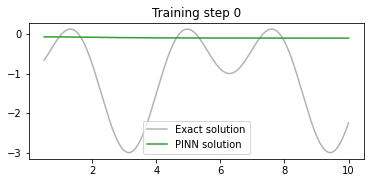

Epoch [1/8000], Loss: 14.8363
BC1 LOSS 0.005490156821906567
BC2 LOSS 8.454514503479004
BC3 LOSS 0.8054558038711548
PDE LOSS 11.337324142456055


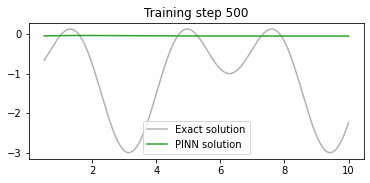

Epoch [501/8000], Loss: 7.6163
BC1 LOSS 0.001591147156432271
BC2 LOSS 8.745656967163086
BC3 LOSS 0.9009654521942139
PDE LOSS 3.102417230606079


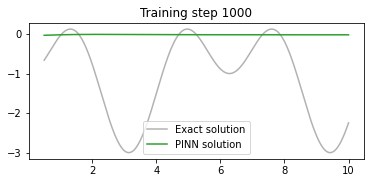

Epoch [1001/8000], Loss: 5.6985
BC1 LOSS 0.0003538353194016963
BC2 LOSS 8.927268981933594
BC3 LOSS 0.9625594615936279
PDE LOSS 0.8370702862739563


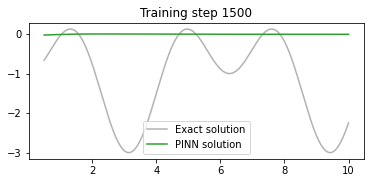

Epoch [1501/8000], Loss: 5.4721
BC1 LOSS 0.0001104429829865694
BC2 LOSS 8.999784469604492
BC3 LOSS 0.9878886342048645
PDE LOSS 0.5313242673873901


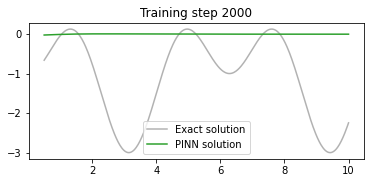

Epoch [2001/8000], Loss: 5.4630
BC1 LOSS 7.919676863821223e-05
BC2 LOSS 9.014273643493652
BC3 LOSS 0.9934878349304199
PDE LOSS 0.5100439190864563


KeyboardInterrupt: 

In [14]:
# define a neural network to train
pinn = FCN(1, 1, 64, 5)

# define boundary points, for the boundary loss
x_boundary = torch.tensor(1.047197551196597).view(-1,1).requires_grad_(True)# (1, 1)

# define training points over the entire domain, for the physics loss
x_physics = torch.linspace(0.5, 10, 500).view(-1,1).requires_grad_(True)# (20, 1)

x_test = torch.linspace(0.5,10,500).view(-1,1) #(200, 1)

u_exact = exact_solution(x_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-6)
num_epochs = 8000
losses = []
for i in range(num_epochs+1):
    optimiser.zero_grad()

    # using the following hyperparameters
    lambda1, lambda2 = 0.5, 0.9

    # compute boundary loss
    u = pinn(x_boundary)# (1, 1)
    loss1 = (torch.squeeze(u) -0)**2
    x_boundary2 = torch.tensor(3.141592653).view(-1,1).requires_grad_(True)# (1, 1)
    u = pinn(x_boundary2)
    loss3 = (torch.squeeze(u)+3)**2
    x_boundary3 = torch.tensor(6.283185307179586476925286766559).view(-1,1).requires_grad_(True)# (1, 1)
    u = pinn(x_boundary3)
    loss4 = (torch.squeeze(u)+1)**2

    # compute physics loss
    u = pinn(x_physics)  # (20, 1)
    dudx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    # loss2 = torch.mean((dudx - (u*x_physics)-x_physics))
    loss2 = torch.mean((dudx + 2*u*torch.tan(x_physics)-torch.sin(x_physics))**2)

    # backpropagate joint loss, take optimiser step
    loss = lambda1* loss1 + lambda2* loss2 + lambda1*loss3 + lambda1*loss4
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

    # plot the result as training progresses
    if i % 500 == 0:
        u = pinn(x_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.plot(x_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(x_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()
        print(f"Epoch [{i+1}/{num_epochs}], Loss: {loss.item():.4f}")
        print(f'BC1 LOSS {loss1}')
        print(f'BC2 LOSS {loss3}')
        print(f'BC3 LOSS {loss4}')
        print(f'PDE LOSS {loss2}')


plt.plot(range(1, num_epochs+2), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

Avg Percentage Error is: 100.352783203125


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

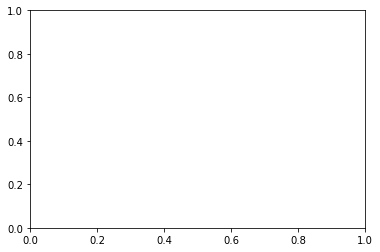

In [15]:
diff = abs(u_exact-u)/abs(0.01*u_exact)
print(f'Avg Percentage Error is: {torch.mean(diff[1:])}')
plt.plot(x_test, diff, label='Percentage error b/w exact and predicted')
plt.xlabel('Length')
plt.ylabel('Error')
plt.title('Error vs Length')
plt.legend()
plt.show()

In [16]:
# Assuming u_exact and u are NumPy arrays
u_exact2 = u_exact.numpy()
u2 = u.numpy()

# Calculate RMSE at each point
rmse_per_point = np.sqrt(np.mean((u_exact2 - u2)**2, axis=1))
overall_rmse = np.sqrt(np.mean((u_exact2 - u2)**2))
print(f'Overall RMSE is: {overall_rmse}')

# Plot the RMSE at each point
plt.plot(x_test, rmse_per_point, label='RMSE between exact and predicted')
plt.xlabel('Length')
plt.ylabel('RMSE')
plt.title('RMSE vs Length')
plt.legend()
plt.show()


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.